In [1]:
import pickle as p
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm import tqdm
from dfa import dfa
import scipy.signal as sig
from sklearn.linear_model import LogisticRegression
from scipy.interpolate import interp1d
from scipy.integrate import romb
plt.rcParams.update({'font.size': 22})
from hsl_functions import *
import glob
from scipy.signal import medfilt,butter
import corner
import scipy

plt.rcParams.update({'font.size': 22})

# Book-keeping Functions
n_splits = 10

def num_to_epoch(epoch_number):
    if epoch_number == 0:
        return 'UP1'
    elif epoch_number == 1:
        return 'UP2'
    elif epoch_number == 2:
        return 'P1'
    elif epoch_number == 3:
        return 'P2'
    elif epoch_number == 4:
        return 'REC'
    else:
        raise Exception('Invalid Epoch Number')

def num_to_subject(subject_number):
    return 'Subject'+str(subject_number)

def get_signal(measure, epoch, subjno):
    if isinstance(epoch,str):
        return np.ravel(df.loc[measure, epoch][num_to_subject(subjno)])
    elif isinstance(epoch, int):
        return np.ravel(df.loc[measure, num_to_epoch(epoch)][num_to_subject(subjno)])

def get_split_signal(measure, epoch, subjno, splitno):
    if isinstance(epoch,str):
        return np.array_split(np.ravel(df.loc[measure, epoch][num_to_subject(subjno)]), n_splits)[splitno]
    elif isinstance(epoch, int):
        return np.array_split(np.ravel(df.loc[measure, num_to_epoch(epoch)][num_to_subject(subjno)]),n_splits)[splitno]
    
def full_signal(measure, subjno):
    return np.concatenate((
        np.ravel(df.loc[measure, num_to_epoch(0)][num_to_subject(subjno)]),
        np.ravel(df.loc[measure, num_to_epoch(1)][num_to_subject(subjno)]),
        np.ravel(df.loc[measure, num_to_epoch(2)][num_to_subject(subjno)]),
        np.ravel(df.loc[measure, num_to_epoch(3)][num_to_subject(subjno)]),
        np.ravel(df.loc[measure, num_to_epoch(4)][num_to_subject(subjno)]),
    ))

def is_perturbed(epoch):
    if epoch == 0 or epoch == 1 or epoch == 4:
        return 0
    elif epoch == 2 or epoch == 3:
        return 1
    
def scaled_correlation_time(signal1, signal2):
    signal1 = (signal1 - np.mean(signal1))/np.std(signal1)
    signal2 = (signal2 - np.mean(signal2))/np.std(signal2)
    acorr = np.correlate(signal1, signal2, mode='full')
    acorr = acorr[(acorr.size // 2 ):] / np.max(acorr)
#     plt.plot(acorr)
    tau = np.argmax([acorr < 1/np.exp(1)])
    return tau / len(acorr)

def correlation_integral(signal1, signal2):
    signal1 = (signal1 - np.mean(signal1))/np.std(signal1)
    signal2 = (signal2 - np.mean(signal2))/np.std(signal2)
    acorr = np.correlate(signal1, signal2, mode='full')
    acorr = acorr[(acorr.size // 2 ):] / np.max(acorr)
#     plt.plot(acorr)
    integral = np.trapz(acorr)
    return integral

def plot_full_experiment(measure, subjno):
    s1 = np.ravel(df.loc[measure, num_to_epoch(0)][num_to_subject(subjno)])
    s2 = np.ravel(df.loc[measure, num_to_epoch(1)][num_to_subject(subjno)])
    s3 = np.ravel(df.loc[measure, num_to_epoch(2)][num_to_subject(subjno)])
    s4 = np.ravel(df.loc[measure, num_to_epoch(3)][num_to_subject(subjno)])
    s5 = np.ravel(df.loc[measure, num_to_epoch(4)][num_to_subject(subjno)])
    fullsignal = np.concatenate((s1,s2,s3,s4,s5))
    plt.plot(fullsignal,'k',label = measure)
    plt.axvline(x = len(s1), color = 'k', linestyle = '--')
    plt.axvline(x = len(s1)+len(s2), color = 'k', linestyle = '--')
    plt.axvline(x = len(s1)+len(s2)+len(s3), color = 'k', linestyle = '--')
    plt.axvline(x = len(s1)+len(s2)+len(s3)+len(s4), color = 'k', linestyle = '--')
    plt.legend()

df = p.load(open('df.p','rb'))

all_subjects = np.concatenate((np.arange(11,25),np.arange(26,45)))

## IBI Functions

In [2]:
def ibi_iqr(signal):
    return scipy.stats.iqr(signal)

def ibi_std(signal):
    return np.std(signal)

def rmssd(signal):
    return np.sqrt(np.mean(np.square(np.diff(signal))))

def ibi_passbands(signal):
    fs,pxx = scipy.signal.periodogram(signal, nfft = 1000, scaling = 'density', detrend = 'constant')

    vlfband = (fs > 0.0033)*(fs < 0.04)
    lfband = (fs > 0.04)*(fs < 0.15)
    hfband = (fs > 0.15) * (fs < 0.4)

    vlf_integral = np.trapz(pxx[vlfband],fs[vlfband]) #unsure what this does
    lf_integral = np.trapz(pxx[lfband],fs[lfband])
    hf_integral = np.trapz(pxx[hfband],fs[hfband])

    return [vlf_integral,lf_integral,hf_integral]

def ibi_lfhf(signal):
    return ibi_passbands(signal)[1]/ibi_passbands(signal)[2]

In [3]:
def ibi_features(signal):
    functions = [ibi_iqr, ibi_std, rmssd, ibi_lfhf]
    measure_names = ['ibi_iqr', 'ibi_std', 'ibi_rmssd', 'ibi_lf/hf']
    features = np.asarray([func(signal) for func in functions]).reshape(-1,1)
    fdf = pd.DataFrame(columns = measure_names, data = features.T)
    return fdf

In [4]:
signal = get_signal('IBI', 2, 23)

In [5]:
feat = ibi_features(signal)

## EDA Functions

In [6]:
def eda_median(signal):
    return np.median(signal)

def mean_firstdiff(signal):
    return np.mean(np.abs(np.diff(signal, n=1)))

def std_firstdiff(signal):
    return np.std(np.abs(np.diff(signal, n=1)))

def mean_seconddiff(signal):
    return np.mean(np.abs(np.diff(signal, n=2)))

def std_seconddiff(signal):
    return np.std(np.abs(np.diff(signal, n=2)))

def find_peaks(signal):
    #normalize function
    norm_signal = medfilt((signal-np.mean(signal))/np.std(signal), 31)
    #find peaks
    peaks, _ = sig.find_peaks(norm_signal, distance = len(signal)/12, prominence = 0.25)
    if len(peaks) == 0:
        peaks, _ = sig.find_peaks(norm_signal, distance = len(signal)/14, prominence = 0.1)
    if len(peaks) == 0:
        peaks, _ = sig.find_peaks(norm_signal, distance = len(signal)/14)
    min_0 = np.argmin(signal[0:peaks[0]])
    min_peaks = [min_0]
    for i in range(1,len(peaks)):
        min_i = np.argmin(signal[peaks[i-1]:peaks[i]])
        min_peaks.append((peaks[i-1]+min_i))
    return peaks, min_peaks

def orienting_features(signal):
    peaks, onsets = find_peaks(signal)
    num_onsets = len(onsets)
    sum_peaks = sum(signal[peaks])
    sum_onsets = sum(signal[onsets])
    sum_difference = sum_peaks - sum_onsets
    
    orienting_duration = []
    for i in range(len(peaks)):
        orienting_duration.append(peaks[i]-onsets[i])
    mean_od = np.mean(orienting_duration)
    sum_od = sum(orienting_duration)
    
    areas = []
    for i in range(len(peaks)):
        areas.append(0.5*orienting_duration[i]*peaks[i])
    
    sum_areas = sum(areas)
    
    mean_amplitude = []
    for i in range(len(peaks)):
        mean_amplitude.append((peaks[i]+onsets[i])/2)
    
    mean_amp = np.mean(mean_amplitude)
    total_amp = sum(mean_amplitude)
    return [num_onsets, sum_onsets, sum_peaks, sum_difference, sum_areas, sum_od, mean_od, mean_amp, total_amp]

def EDA_passbands(signal):
    fs,pxx = scipy.signal.periodogram(signal, nfft = 1000, scaling = 'density', detrend = 'linear')
    # plt.figure()
    # plt.plot(fs,pxx)
    # plt.xlim(0,0.05)
    # plt.xlabel('Frequency (Hz.)')
    # plt.ylabel('Spectral Density')

    vlfband = (fs > 0.001)*(fs < 0.045)
    lfband = (fs > 0.045)*(fs < 0.15)
    hfband = (fs > 0.15) * (fs < 0.25)

    # plt.figure(figsize = (13,7))
    # plt.plot(fs,pxx,'k')
    # #plt.xlim(0,0.05)
    # plt.xlabel('Frequency (Hz.)')
    # plt.ylabel('Spectral Density')
    # plt.plot(fs,vlfband*np.max(pxx),label = 'VLF')
    # plt.plot(fs,lfband*np.max(pxx),label = 'LF')
    # plt.plot(fs,hfband*np.max(pxx),label = 'HF')
    # plt.title('IBI Frequency Passbands')
    # plt.legend()

    vlf_integral = np.trapz(pxx[vlfband],fs[vlfband])
    lf_integral = np.trapz(pxx[lfband],fs[lfband])
    hf_integral = np.trapz(pxx[hfband],fs[hfband])

    return [vlf_integral,lf_integral,hf_integral]

def eda_lfhf(signal):
    return EDA_passbands(signal)[1]/EDA_passbands(signal)[2]

def eda_features(signal):
    functions = [eda_median, mean_firstdiff, std_firstdiff, mean_seconddiff, std_seconddiff, eda_lfhf]
    measure_names = ['eda_median', 'eda_mean1diff', 'eda_std1diff', 'eda_mean2diff', 'eda_std2diff', 'eda_lf/hf']
    features = np.asarray([func(signal) for func in functions]).reshape(-1,1)
    fdf = pd.DataFrame(columns = measure_names, data = features.T)
    
    orient_features = np.asarray(orienting_features(signal)).reshape(-1,1)
    orient_featurenames = ['eda_num_onsets', 'eda_sum_onsets', 'eda_sum_peaks', 'eda_sum_difference',\
                           'eda_sum_areas', 'eda_sum_od', 'eda_mean_od', 'eda_mean_amp', 'eda_total_amp']
    ofdf = pd.DataFrame(columns = orient_featurenames, data = orient_features.T)
    
    return fdf.join(ofdf)

## Multivar Functions

In [7]:
def resample(signal1, signal2):
    #samples = np.max([len(signal1), len(signal2)])
    ts = np.linspace(0, 1500, 1500)

    f1 = scipy.interpolate.interp1d(np.linspace(0, 1500, len(signal1)), signal1, kind = 'linear')
    signal1 = f1(ts)

    f2 = scipy.interpolate.interp1d(np.linspace(0, 1500, len(signal2)), signal2, kind = 'linear')
    signal2 = f2(ts)
    
    return signal1, signal2

def normalize(signal):
    return (signal - np.mean(signal)) / np.std(signal)

def detrend(signal):
    line = np.polyfit(np.arange(len(signal)), signal, 2)
    return signal - np.polyval(line, np.arange(len(signal))) 

In [8]:
def xcorr_lagtime(signal1, signal2, make_plot = False, sig1 = '', sig2 = ''):
    signal1, signal2 = resample(signal1, signal2)
    
    X = (signal1 - np.mean(signal1)) / np.std(signal1)
    Y = (signal2 - np.mean(signal2)) / np.std(signal2)
    
#     X = detrend(X)
#     Y = detrend(Y)
    
    xcorr = np.correlate(X, Y, mode='full')
    xcorr = xcorr[(xcorr.size // 2 ):] / np.max(xcorr)
    
    tau = np.argmax(xcorr)
    
    if make_plot:
        plt.figure(figsize = (12,10))
        plt.subplot(211)
        
        plt.plot(X, label = sig1)
        plt.plot(Y, label = sig2)
        plt.legend()
        plt.xlabel('Time (s)')
        plt.ylabel('Normalized Signal')
        
        plt.subplot(212)
        
        plt.plot(xcorr, 'k', label = 'Cross-Correlation')
        plt.axvline(tau, color = 'k', linestyle = '--')
        plt.xlabel('Lag (s)')
        plt.ylabel('Coefficient')
        plt.legend()
        
        plt.tight_layout()
    
    return tau

def Cxyy(x, y, r, s, N):
    z = 0
    m = np.max([r, s])
    for i in range(0, N-m-1):
        z += x[i] * y[i+r] * y[i+s]
    z /= (N-m)
    return z

def xbicorr(x, y):
    
    x,y = resample(x,y)
    x,y = normalize(x), normalize(y)
    
    N = len(x)
    L = int(np.floor(N**0.4))
    
    z = 0
    for s in range(2, L+1):
        for r in range(1, L+1):
            m = np.max([r, s])
            z += (N-m) * Cxyy(x, y, r, s, N)**2
    return z

In [9]:
def multi_features(signal1, signal2, name):
    functions = [xcorr_lagtime, xbicorr]
    measure_names = [name+'_xcorr_lag', name+'_xbicorr']
    features = np.asarray([func(signal1, signal2) for func in functions]).reshape(-1,1)
    fdf = pd.DataFrame(columns = measure_names, data = features.T)
    return fdf

## Shimmer Functions

In [10]:
shimfiles = glob.glob('shimmerData/*/*')

def get_shimmer(subjno, part, epochno):
    epoch = num_to_epoch(epochno)
    if epoch == 'REC':
        epoch = 'Rec'
    elif epoch == 'P1':
        epoch = '_P1'
    elif epoch == 'P2':
        epoch = '_P2'
    
    for file in shimfiles:
        if str(subjno) in file and part in file and epoch in file:
            data = pd.read_csv(file, header = None)
    try:
        vectors = np.asarray(data[[1,2,3]])
    except:
        print('mising shimmer data. skipping...')
        return np.repeat(np.nan, 1000)
    mean = np.mean(vectors, axis = 0)
    std = np.std(vectors, axis = 0)
    
    vectors = (vectors - mean[np.newaxis,:])

    #plt.plot(vectors)
    
    z_vector = np.linalg.norm(vectors, axis = 1)

    return z_vector

def get_split_shimmer(subjno, part, epochno, splitno):

    z_vector = get_shimmer(subjno,part,epochno)

    return np.array_split(z_vector,n_splits)[splitno]

def signal_statistics(signal):
    mean = np.mean(signal)
    std = np.std(signal)
    skewness = stats.skew(signal)
    kurtosis = stats.kurtosis(signal)
    maximum = np.max(signal)
    minimum = np.min(signal)
    iqr = stats.iqr(signal)
    variation = stats.variation(signal)
    entropy = stats.entropy(np.abs(signal))
    dfa_exp = dfa(signal)
    return np.asarray([mean, std, skewness, kurtosis, maximum, minimum, iqr, variation, entropy, dfa_exp])

def spectrum_statistics(signal):
    
    fs,pxx = scipy.signal.periodogram(signal, fs = 50, nfft = 1000, scaling = 'density', detrend = 'constant')
    
#     plt.plot(fs,pxx)
    #plt.xlim(0,0.1)

    peak = fs[np.argmax(pxx)]
    peakmag = np.max(pxx)
    integral = np.trapz(pxx,fs)
    energy = np.dot(pxx,pxx)
    shannon = np.sum(pxx*np.log(1/pxx))

    # Add wavelet analysis

    return [peak, peakmag, integral, energy, shannon]

def bodyshimmer_features(signal):
    shim_stats = signal_statistics(signal).reshape(-1,1)
    stat_names = ['bodyshim_mean', 'bodyshim_std', 'bodyshim_skewness', 'bodyshim_kurtosis', \
'bodyshim_maximum', 'bodyshim_minimum', 'bodyshim_iqr', 'bodyshim_variation', 'bodyshim_entropy', 'bodyshim_dfa']
    fdf = pd.DataFrame(columns = stat_names, data = shim_stats.T)
    
    spec_stats = np.asarray(spectrum_statistics(signal)).reshape(-1,1)
    specstat_names = ['bodyshim_peakfreq','bodyshim_peakpower','bodyshim_powerint','bodyshim_specenergy',\
                   'bodyshim_shannon']
    spec_fdf = pd.DataFrame(columns = specstat_names, data = spec_stats.T)
    
    return fdf.join(spec_fdf)

def headshimmer_features(signal):
    shim_stats = signal_statistics(signal).reshape(-1,1)
    stat_names = ['headshim_mean', 'headshim_std', 'headshim_skewness', 'headshim_kurtosis', \
'headshim_maximum', 'headshim_minimum', 'headshim_iqr', 'headshim_variation', 'headshim_entropy', 'headshim_dfa']
    fdf = pd.DataFrame(columns = stat_names, data = shim_stats.T)
    
    spec_stats = np.asarray(spectrum_statistics(signal)).reshape(-1,1)
    specstat_names = ['headshim_peakfreq','headshim_peakpower','headshim_powerint','headshim_specenergy',\
                   'headshim_shannon']
    spec_fdf = pd.DataFrame(columns = specstat_names, data = spec_stats.T)
    
    return fdf.join(spec_fdf)

In [11]:
def hr_features(signal):
    shim_stats = signal_statistics(signal).reshape(-1,1)
    stat_names = ['hr_mean', 'hr_std', 'hr_skewness', 'hr_kurtosis', \
'hr_maximum', 'hr_minimum', 'hr_iqr', 'hr_variation', 'hr_entropy', 'hr_dfa']
    fdf = pd.DataFrame(columns = stat_names, data = shim_stats.T)
    return fdf

In [12]:
def temp_features(signal):
    shim_stats = signal_statistics(signal).reshape(-1,1)
    stat_names = ['temp_mean', 'temp_std', 'temp_skewness', 'temp_kurtosis', \
'temp_maximum', 'temp_minimum', 'temp_iqr', 'temp_variation', 'temp_entropy', 'temp_dfa']
    fdf = pd.DataFrame(columns = stat_names, data = shim_stats.T)
    return fdf

## Compute Features

In [13]:
switchdf = pd.read_csv('switches.csv', header = None, names = np.arange(11,46))
likertdf = pd.read_csv('likert.csv', header = None, names = np.arange(11,46))
vandf = pd.read_csv('van.csv', header = None, names = np.arange(11,46))

In [14]:
n_splits = 1

fdf = pd.DataFrame()
targets = [];
switch_times = [];
likert_scores = [];
vans = [];

for subjno in tqdm(all_subjects):
    for epoch in range(4):
        for splitno in range(n_splits):
            
            ibi_signal = get_split_signal('IBI', epoch, subjno, splitno)
            ibi_df = ibi_features(ibi_signal)
            
            eda_signal = get_split_signal('EDA', epoch, subjno, splitno)
            eda_df = eda_features(eda_signal)
            
            head_shimmer = get_split_shimmer(subjno, 'head', epoch, splitno)
            head_df = headshimmer_features(head_shimmer)
            
            body_shimmer = get_split_shimmer(subjno, 'body', epoch, splitno)
            body_df = bodyshimmer_features(body_shimmer)
            
            hr_signal = get_split_signal('HR', epoch, subjno, splitno)
            hr_df = hr_features(hr_signal)
            
            temp_signal = get_split_signal('TEMP', epoch, subjno, splitno)
            temp_df = temp_features(temp_signal)
            
            hr_eda = multi_features(hr_signal, eda_signal, 'hr-eda')
            temp_eda = multi_features(temp_signal, eda_signal, 'temp-eda')
            hr_temp = multi_features(hr_signal, temp_signal, 'hr-temp')
            
            fdf = pd.concat([fdf, ibi_df.join(eda_df).join(head_df).join(body_df).\
                    join(hr_df).join(temp_df).join(hr_eda).join(temp_eda).join(hr_temp)])
            
            
            
            switch_times.append(switchdf[subjno][epoch] - switchdf[subjno][0])
            
            likert_scores.append(likertdf[subjno][epoch])
            vans.append(vandf[subjno][epoch])


            
            targets.append(is_perturbed(epoch))

  6%|▌         | 2/33 [00:46<11:52, 22.98s/it]

mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...


  9%|▉         | 3/33 [01:00<10:11, 20.37s/it]

mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...


 18%|█▊        | 6/33 [01:56<08:58, 19.95s/it]

mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...


 27%|██▋       | 9/33 [02:37<06:44, 16.86s/it]

mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...


 30%|███       | 10/33 [02:49<05:55, 15.44s/it]

mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...


 82%|████████▏ | 27/33 [08:23<02:08, 21.36s/it]

mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...


100%|██████████| 33/33 [10:19<00:00, 20.37s/it]


In [502]:
deltatimes = [];
for subjno in all_subjects:
    for epoch in range(4):
        deltatimes.append(-switchdf[subjno][epoch+1] + switchdf[subjno][epoch])

In [503]:
deltatimes = np.asarray(deltatimes)
switch_times = np.asarray(switch_times)

## Correlations

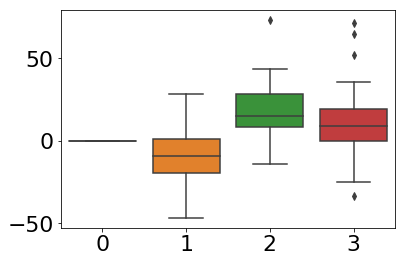

In [504]:
import seaborn as sns

sns.boxplot(data = np.asarray(switch_times).reshape(-1,4));

In [505]:
means = np.mean(np.asarray(switch_times).reshape(-1,4),0)
stds = np.std(np.asarray(switch_times).reshape(-1,4),0) / np.sqrt(len(switch_times)/4)

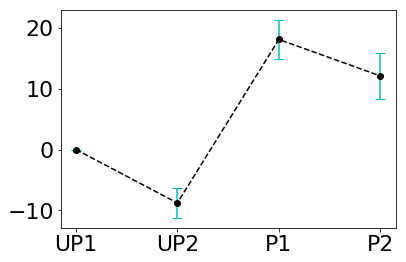

In [506]:
plt.errorbar([0,1,2,3], means, yerr = stds, marker = 'o', color = 'k', linestyle = '--', ecolor = 'c',\
             capsize = 5)
plt.xticks([0,1,2,3], ['UP1', 'UP2', 'P1', 'P2']);

In [507]:
def linear_model(measure, dependent, crop = 'default'):
    if crop is 'default':
        crop = measure < np.Inf
    measure = measure[crop]
    dependent = np.asarray(dependent)[crop]

    plt.scatter(measure, dependent, color = 'k', alpha = 0.5)
    #plt.xlim(0,0.3)
    reg = stats.linregress(measure, dependent)
    x = np.linspace(min(measure), max(measure), 1000)
    y = reg.slope * x + reg.intercept
    plt.plot(x,y, 'r--')
    print('p = %.3f'%reg.pvalue)
    return reg

p = 0.000


LinregressResult(slope=3.8917319345986745, intercept=-5.4929344843356995, rvalue=0.4098913619338079, pvalue=1.0570650013137944e-06, stderr=0.7595586023727019)

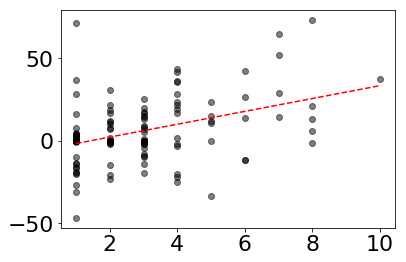

In [508]:
linear_model(np.asarray(likert_scores), switch_times)

Text(0, 0.5, 'Switch Time (seconds)')

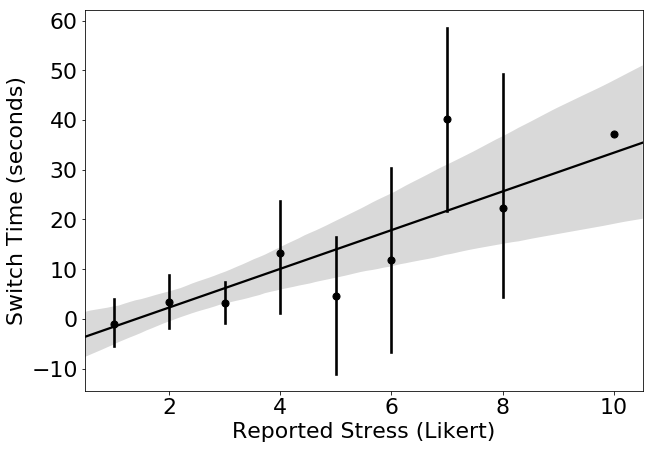

In [509]:
plt.figure(figsize = (10,7))
sns.regplot(np.asarray(likert_scores), switch_times, color = 'k', x_bins = np.arange(1,11), ci = 95)
plt.xlabel('Reported Stress (Likert)')
plt.ylabel('Switch Time (seconds)')

## Damage

p = 0.901


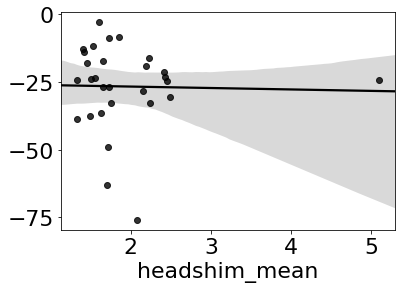

p = 0.251


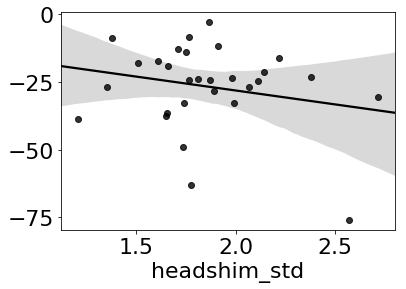

p = 0.842


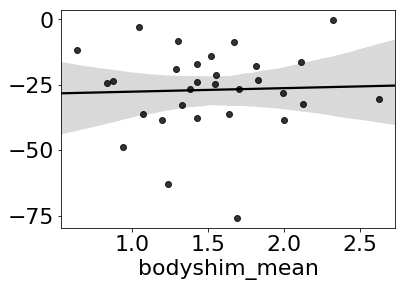

p = 0.977


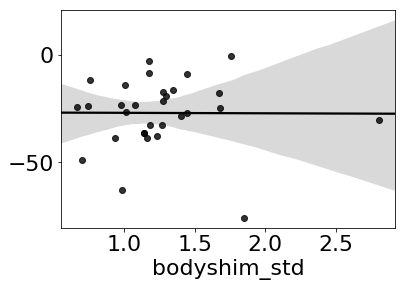

p = 0.926


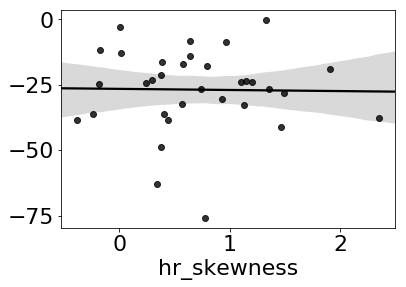

p = 0.623


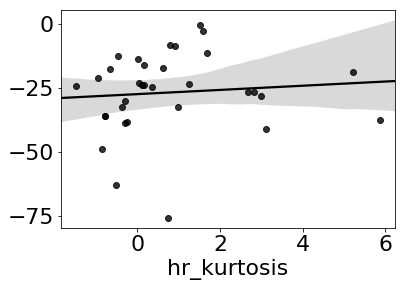

p = 0.031


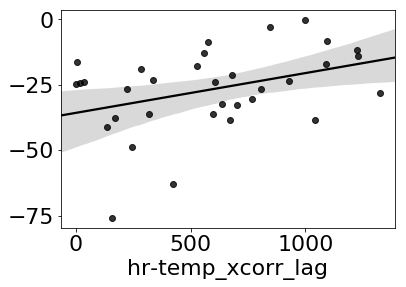

p = 0.160


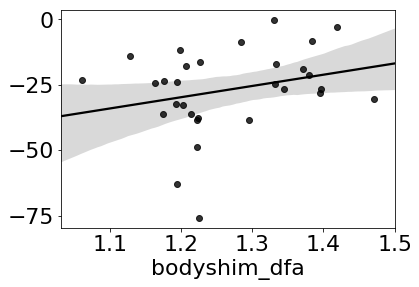

p = 0.509


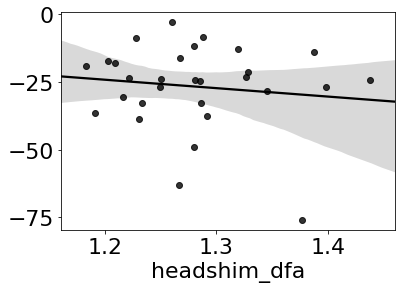

In [511]:
damage_times = deltatimes[1::4]

selected_measures = ['headshim_mean', 'headshim_std', 'bodyshim_mean', 'bodyshim_std',\
                     'hr_skewness', 'hr_kurtosis', 'hr-temp_xcorr_lag', 'bodyshim_dfa', 'headshim_dfa']

for measurename in selected_measures:
    measure = fdf[measurename]
    linear_model(measure[0::4], damage_times)
    plt.close()
    sns.regplot(measure[0::4], damage_times, color = 'k', ci = 95)
    plt.show()

## Adaptation

#### From P1

p = 0.061


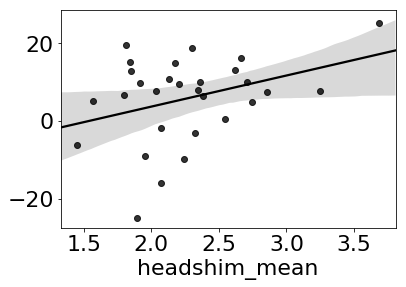

p = 0.042


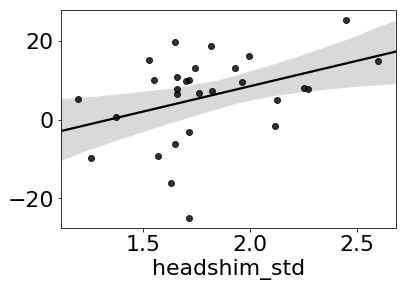

p = 0.101


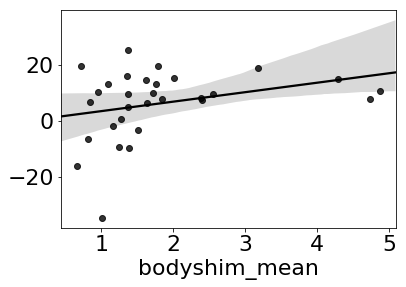

p = 0.025


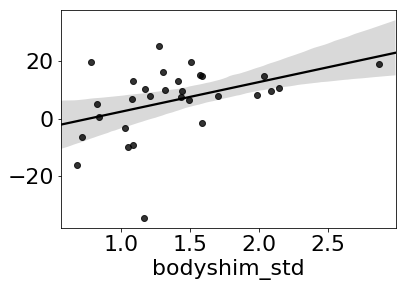

p = 0.035


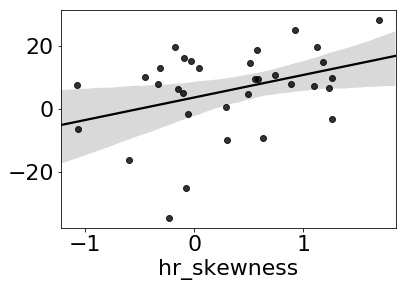

p = 0.022


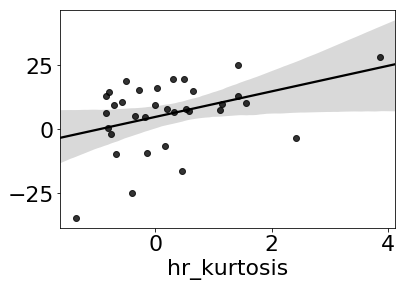

p = 0.070


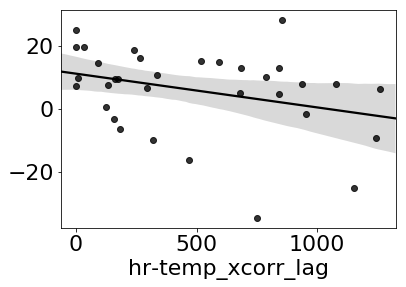

p = 0.061


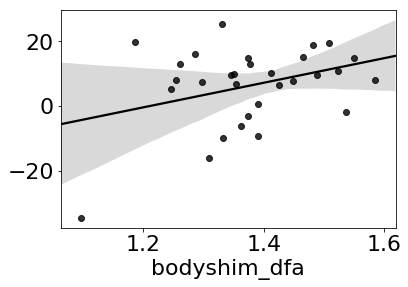

p = 0.176


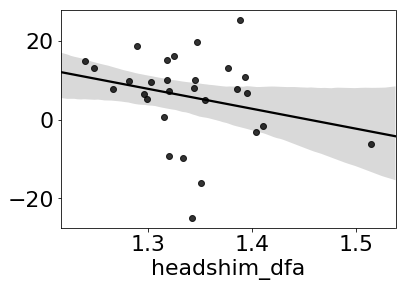

In [512]:
adaptation_times = deltatimes[2::4]

selected_measures = ['headshim_mean', 'headshim_std', 'bodyshim_mean', 'bodyshim_std',\
                     'hr_skewness', 'hr_kurtosis', 'hr-temp_xcorr_lag', 'bodyshim_dfa', 'headshim_dfa']

for measurename in selected_measures:
    measure = fdf[measurename]
    linear_model(measure[2::4], adaptation_times)
    plt.close()
    sns.regplot(measure[2::4], adaptation_times, color = 'k', ci = 95)
    plt.show()

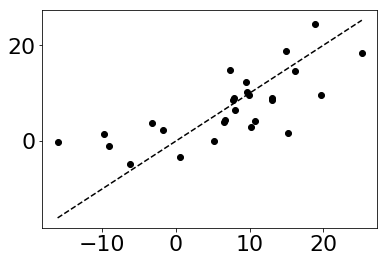

In [513]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
X = np.asarray(fdf[selected_measures])
X = X[2::4 , :]
t = adaptation_times

X_clean = X[np.sum(np.isnan(X),1) == 0]
t_clean = t[np.sum(np.isnan(X),1) == 0]

lr.fit(X_clean,t_clean)

plt.scatter(t_clean, lr.predict(X_clean), color = 'k')
x = np.linspace(min(t_clean), max(t_clean), 1000)
plt.plot(x,x,'k--')

#### From UP1

p = 0.006
bodyshim_mean


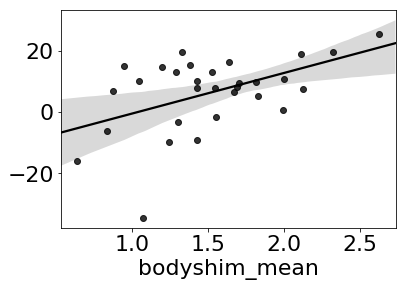

p = 0.019
bodyshim_std


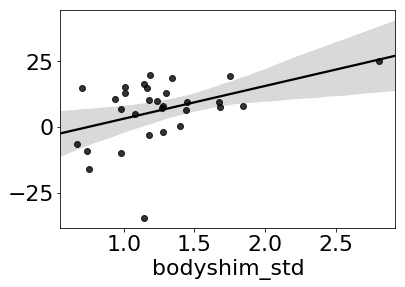

p = 0.046
bodyshim_iqr


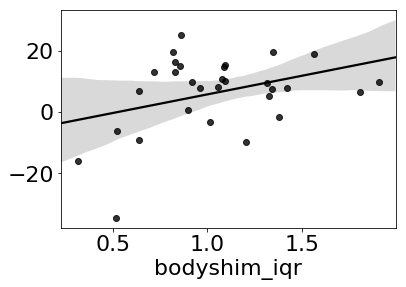

p = 0.018
hr_skewness


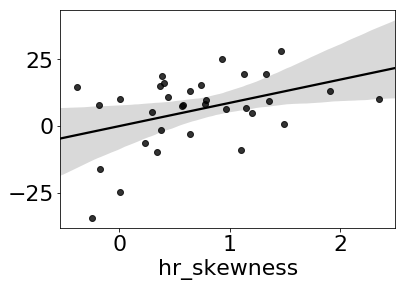

p = 0.081
hr_minimum


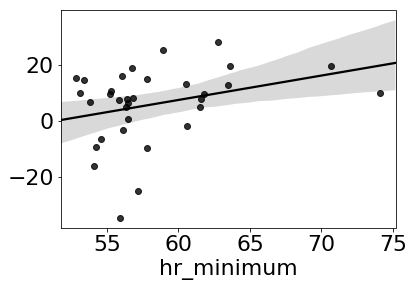

p = 0.023
eda_sum_od


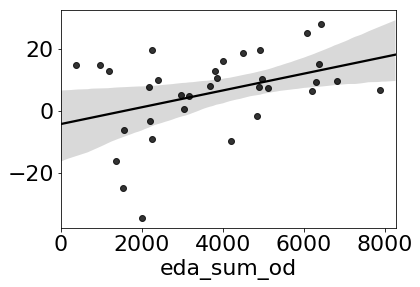

In [484]:
adaptation_times = deltatimes[2::4]

selected_measures = ['bodyshim_mean','bodyshim_std','bodyshim_iqr', 'hr_skewness','hr_minimum','eda_sum_od']

for measurename in selected_measures:
    measure = fdf[measurename]
    linear_model(measure[0::4], adaptation_times)
    plt.close()
    sns.regplot(measure[0::4], adaptation_times, color = 'k', ci = 95)
    print(measurename)
    plt.show()

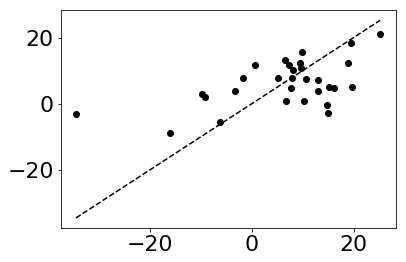

In [490]:
lr = LinearRegression()
X = np.asarray(fdf[selected_measures])
X = X[0::4 , :]
t = adaptation_times

X_clean = X[np.sum(np.isnan(X),1) == 0]
t_clean = t[np.sum(np.isnan(X),1) == 0]

lr.fit(X_clean,t_clean)

plt.scatter(t_clean, lr.predict(X_clean), color = 'k')
x = np.linspace(min(t_clean), max(t_clean), 1000)
plt.plot(x,x,'k--')

## Logistic Regression

In [334]:
notnan = np.sum(np.isnan(fdf),1).values == 0
fdf_clean = fdf[notnan]
targets_clean = np.asarray(targets)[notnan]

In [335]:
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score
from sklearn.model_selection import train_test_split, cross_val_score

In [336]:
X = np.asarray(fdf_clean)
t = np.asarray(targets_clean)

sc = preprocessing.StandardScaler()
X_scaled = sc.fit_transform(X)

In [337]:
scores = mutual_info_classif(X_scaled,t)

Text(0.5, 1.0, 'Mutual Information Feature Selection')

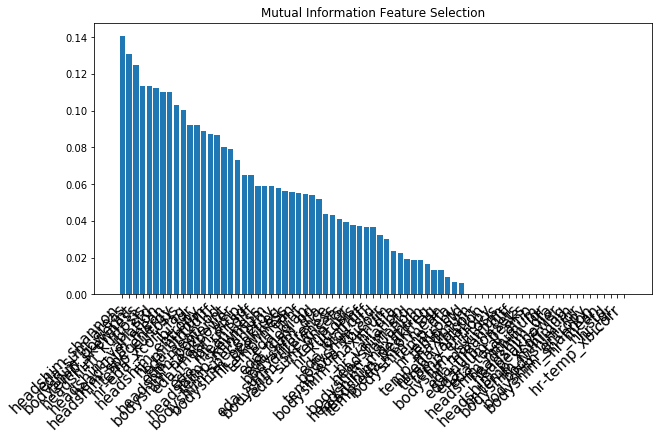

In [338]:
plt.figure(figsize=(10,5))
sortidx = np.argsort(-scores)
plt.bar(fdf.columns[sortidx],height=scores[sortidx],)
plt.xticks(rotation=45, ha='right',fontsize=15);
plt.title('Mutual Information Feature Selection')

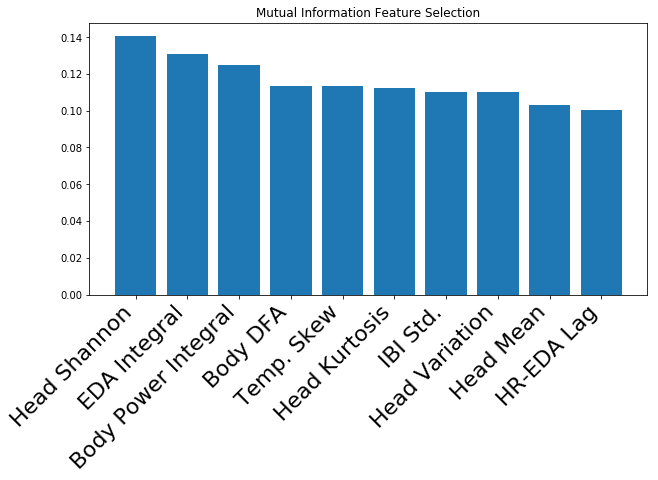

In [339]:
plt.figure(figsize=(10,5))
sortidx = np.argsort(-scores)
plt.bar(fdf.columns[sortidx][0:10],height=scores[sortidx][0:10],)
plt.xticks(np.arange(10), ['Head Shannon', 'EDA Integral', 'Body Power Integral', 'Body DFA', 'Temp. Skew', \
                          'Head Kurtosis', 'IBI Std.', 'Head Variation', 'Head Mean', 'HR-EDA Lag'])
plt.xticks(rotation=45, ha='right',fontsize=22);
plt.title('Mutual Information Feature Selection')
plt.savefig('feature_selection.pdf', bbox_inches = 'tight')

In [340]:
X = np.asarray(fdf_clean)
sc = preprocessing.StandardScaler()
X_scaled = sc.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, t, test_size = 0.25, shuffle = True)

Accuracy = 70.370 percent


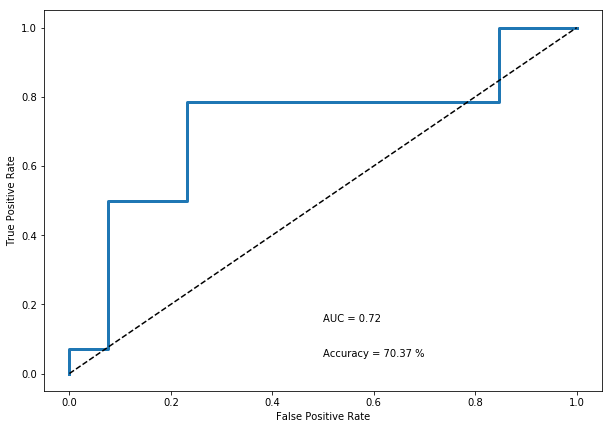

In [341]:
clf = linear_model.LogisticRegression(solver = 'newton-cg', max_iter = 1000000, tol = 0.000001)

clf.fit(X_train, y_train)

lr_fpr,lr_tpr,_ = roc_curve(y_test, clf.predict_proba(X_test)[:,1])

print('Accuracy = %.3f percent'%(clf.score(X_test, y_test)*100))

plt.figure(figsize = (10,7))
plt.plot(lr_fpr,lr_tpr, linewidth = 3)
x = np.linspace(0,1,100)
plt.plot(x,x,'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.text(0.5,0.15, 'AUC = %.2f'%auc(lr_fpr, lr_tpr))
plt.text(0.5,0.05, 'Accuracy = %.2f %%'%(clf.score(X_test, y_test)*100))
plt.savefig('auc.pdf', bbox_inches = 'tight')

In [342]:
print('X-val accuracy: %.2f percent'%(np.mean(cross_val_score(clf, X_scaled, t, cv = 8)*100)))

X-val accuracy: 80.65 percent


Text(0.3, 0.6, 'F-1 Score = 0.69')

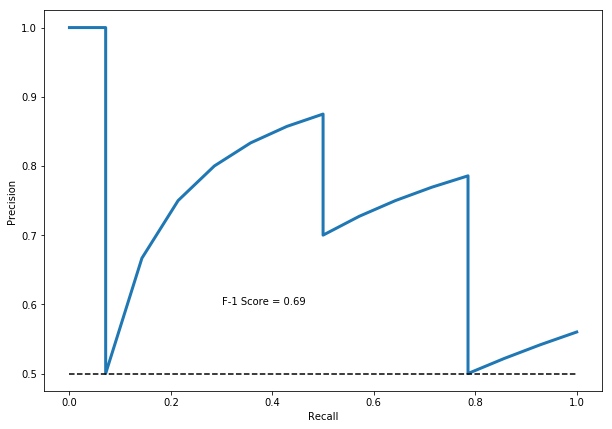

In [343]:
precision, recall, thresholds = precision_recall_curve(y_test, clf.predict_proba(X_test)[:,1])
f1 = f1_score(y_test, clf.predict(X_test))
plt.figure(figsize = (10,7))
plt.plot(recall, precision, linewidth = 3)
plt.plot(x, np.repeat(0.5, len(x)), 'k--')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.text(0.3,0.6, 'F-1 Score = %.2f'%f1)

## SVM

In [127]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions

In [128]:
X = np.asarray(fdf_clean)
t = np.asarray(targets_clean)

sc = preprocessing.StandardScaler()
X_scaled = sc.fit_transform(X)

In [26]:
gs = np.logspace(-10, 0, 35)

Cs = np.logspace(-5, 10, 35)

hparams = [];
score_array = [];

for g in tqdm(gs):
    for C in Cs:
        
        svm = SVC(gamma = g, C = C)
        scores = cross_val_score(svm, X_scaled, t, cv = 5)
        
        score_array.append(np.mean(scores))
        hparams.append([g, C])

100%|██████████| 35/35 [00:09<00:00,  3.67it/s]


In [27]:
hparams = np.asarray(hparams)
score_array = np.asarray(score_array)

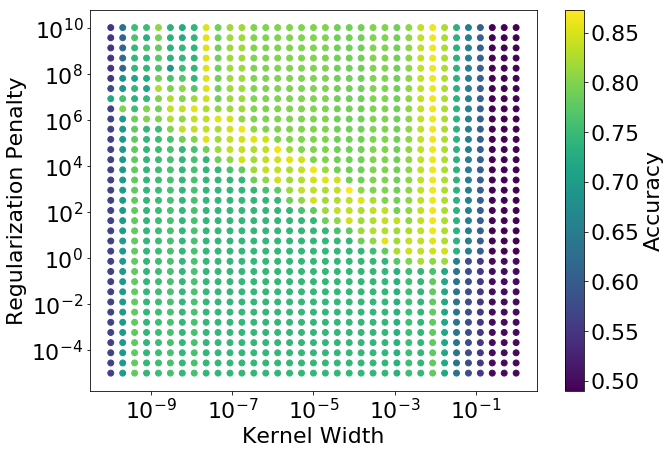

In [59]:
plt.rcParams.update({'font.size': 22})
fig = plt.figure(figsize = (10,7))
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')

plt.scatter(hparams[:,0], hparams[:,1], c = score_array, s = 35, cmap = 'viridis')
cmap = plt.colorbar()
plt.xlabel('Kernel Width')
plt.ylabel('Regularization Penalty')
cmap.ax.set_ylabel('Accuracy')

plt.savefig('svm.pdf')

In [60]:
maxidx = np.argmax(score_array)
chosen = hparams[maxidx]
print(chosen)

[7.62698586e-05 8.73326162e+02]


In [61]:
svm = SVC(gamma = chosen[0], C = chosen[1])

scores = cross_val_score(svm, X_scaled, t, cv = 5)

np.mean(scores)

0.8727272727272727

## Bifuracate Dataset

In [62]:
def plot_roc(dataframe):
    X = np.asarray(dataframe)
    t = np.asarray(targets_clean)

    sc = preprocessing.StandardScaler()
    X_scaled = sc.fit_transform(X)

    clf = linear_model.LogisticRegression(solver = 'newton-cg', max_iter = 1000000, tol = 0.000001)

    clf.fit(X_scaled, t)

    lr_fpr,lr_tpr,_ = roc_curve(t, clf.predict_proba(X_scaled)[:,1])

    print('Accuracy = %.3f percent'%(clf.score(X_scaled, t)*100))

    plt.figure(figsize = (10,7))
    plt.plot(lr_fpr,lr_tpr, linewidth = 3)
    x = np.linspace(0,1,100)
    plt.plot(x,x,'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.text(0.5,0.1, 'AUC = %.2f'%auc(lr_fpr, lr_tpr));

In [63]:
ibi_bool = [('ibi' in fdf_clean.columns[ii]) for ii in range(len(fdf_clean.columns))]
hshim_bool = [('headshim' in fdf_clean.columns[ii]) for ii in range(len(fdf_clean.columns))]
bshim_bool = [('bodyshim' in fdf_clean.columns[ii]) for ii in range(len(fdf_clean.columns))]
eda_bool = [('eda' in fdf_clean.columns[ii]) for ii in range(len(fdf_clean.columns))]
hr_bool = [('hr' in fdf_clean.columns[ii]) for ii in range(len(fdf_clean.columns))]
temp_bool = [('temp' in fdf_clean.columns[ii]) for ii in range(len(fdf_clean.columns))]

In [64]:
ibi_df = fdf_clean[fdf_clean.columns[ibi_bool]]
hshim_df = fdf_clean[fdf_clean.columns[hshim_bool]]
bshim_df = fdf_clean[fdf_clean.columns[bshim_bool]]
eda_df = fdf_clean[fdf_clean.columns[eda_bool]]
hr_df = fdf_clean[fdf_clean.columns[hr_bool]]
temp_df = fdf_clean[fdf_clean.columns[temp_bool]]

dataframes = [hshim_df, bshim_df, eda_df, hr_df, temp_df, fdf_clean]
dfnames = ['Head', 'Body', 'EDA', 'HR', 'Temp.', 'Multivariate']

Accuracy = 86.111 percent
Accuracy = 80.556 percent
Accuracy = 71.296 percent
Accuracy = 63.889 percent
Accuracy = 67.593 percent
Accuracy = 100.000 percent


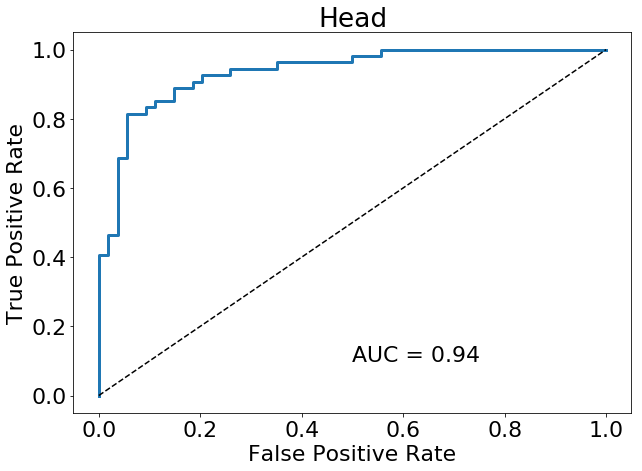

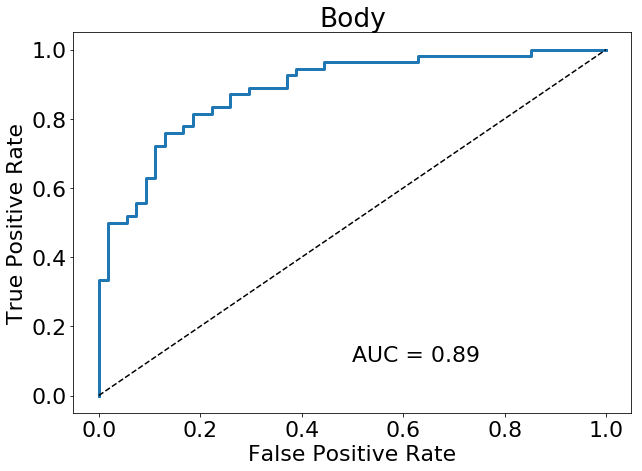

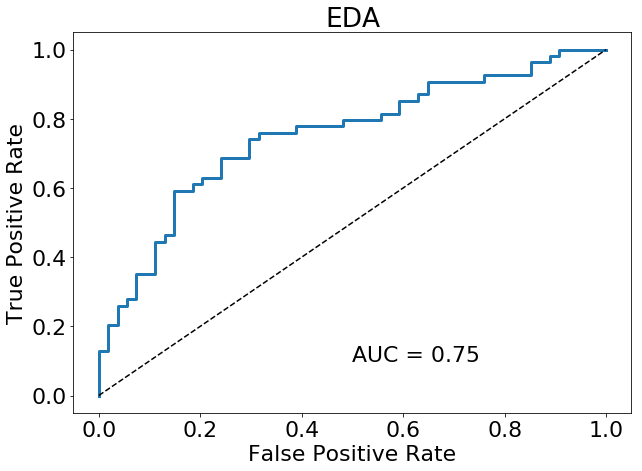

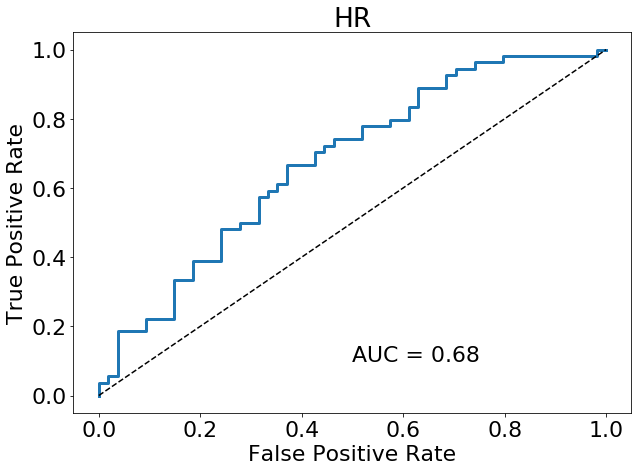

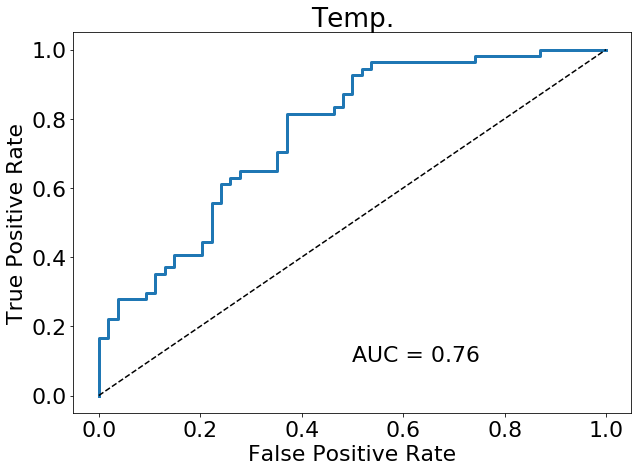

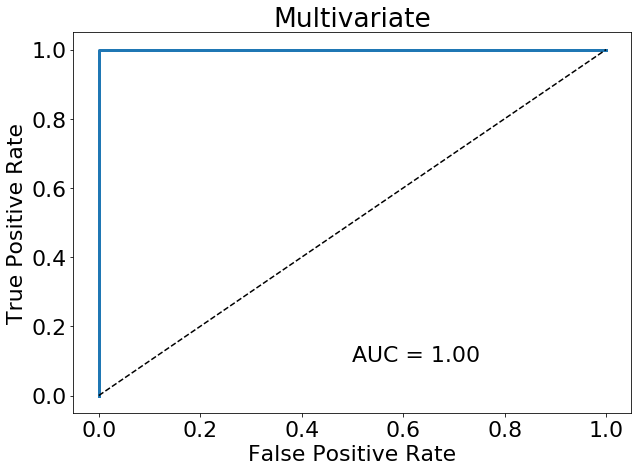

In [66]:
ct = 0;
for dataframe in dataframes:
    plot_roc(dataframe)
    plt.title(dfnames[ct])
    plt.savefig(dfnames[ct]+'_auc.pdf', bbox_inches = 'tight')
    ct += 1

### Comparison

In [281]:
def cval_score(dataframe):
    X = np.asarray(dataframe)
    t = np.asarray(targets_clean)
    sc = preprocessing.StandardScaler()
    X_scaled = sc.fit_transform(X)
    clf = linear_model.LogisticRegression(solver = 'newton-cg', max_iter = 1000000, tol = 0.000001)

    scores = cross_val_score(clf, X_scaled, t, cv = 8)
    
    return np.mean(scores), np.std(scores)

In [282]:
df_scores = [];
df_stds = [];
for dataframe in dataframes:
    res = cval_score(dataframe)
    df_scores.append(res[0]*100)
    df_stds.append(res[1]*100 / np.sqrt(5))

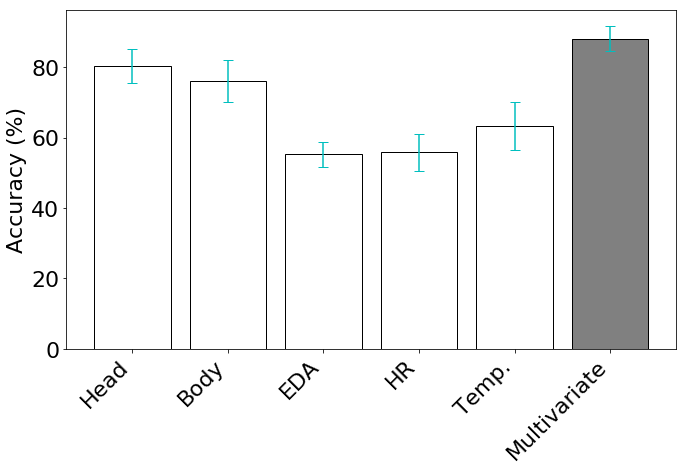

In [324]:
plt.figure(figsize = (10,7))
plt.rcParams.update({'font.size': 22})

x = np.arange(len(df_scores))
plt.bar(x, df_scores, yerr = df_stds, ecolor = 'c', capsize = 5,\
            color = ['none','none','none','none','none', 'grey'], edgecolor = 'k')
plt.xticks(x, dfnames, rotation=45, ha='right')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.savefig('comparison.pdf', bbox_inches = 'tight')